In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
traj = np.load('/content/drive/MyDrive/Kalil_trr/traj_coor_new_256_500ps.npy')
vel = np.load('/content/drive/MyDrive/Kalil_trr/traj_vel_new_256_500ps.npy')
length = 256
trajx = [[] for i in range(length)]
trajy = [[] for i in range(length)]
trajz = [[] for i in range(length)]
for i in range(length):
  for j in range(2000):
    trajx[i].append(traj[i][j][0])
    trajy[i].append(traj[i][j][1])
    trajz[i].append(traj[i][j][2])
# trajx = [[row[i] for row in trajx] for i in range(len(trajx[0]))]
# trajy = [[row[i] for row in trajy] for i in range(len(trajy[0]))]
# trajz = [[row[i] for row in trajz] for i in range(len(trajz[0]))]


In [ ]:
for i in tqdm(range(0,1000,1)):
    s_in = np.zeros((length,3,1000))
    s_out = np.zeros((length,3,1000))
    for j in range(length): 
        s_in[j,0] = trajx[j][::2]
        s_out[j,0] = trajx[j][1::2]
        s_in[j,1] = trajy[j][::2]
        s_out[j,1] = trajy[j][1::2]
        s_in[j,2] = trajz[j][::2]
        s_out[j,2] = trajz[j][1::2]

din = np.array(s_in).transpose(2, 0, 1)
dout = np.array(s_out).transpose(2, 0, 1)


100%|██████████| 1000/1000 [00:47<00:00, 21.21it/s]


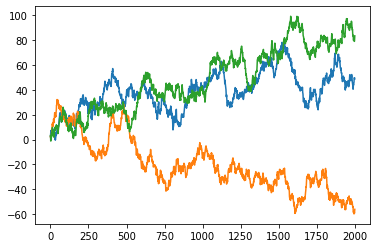

In [ ]:
plt.plot(trajx[1],label='x_true')
plt.plot(trajy[1],label='y_true')
plt.plot(trajz[1],label='z_true')

In [ ]:
print(np.shape(din))
print(np.shape(dout))

(1000, 256, 3)
(1000, 256, 3)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(din, dout, test_size=0.2, random_state=42)
print(np.shape(x_train))
print(np.shape(x_test))
print(np.shape(y_train))
print(np.shape(y_test))

(800, 256, 3)
(200, 256, 3)
(800, 256, 3)
(200, 256, 3)


In [ ]:
cd /content/drive/MyDrive/gray_scott_results

/content/drive/.shortcut-targets-by-id/1JV7hS7EmJJsIJBj6IGG6rYBPHje96cuY/gray_scott_results


In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data_utils
from typing import List, Tuple

import sys
import os

import numpy as np
import math
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
from scipy.special import eval_legendre
from sympy import Poly, legendre, Symbol
import h5py

from sklearn.model_selection import train_test_split


import operator
from functools import reduce
from functools import partial
from timeit import default_timer

from utils_3d import train, test, LpLoss, get_filter, UnitGaussianNormalizer

In [ ]:
x_train = torch.from_numpy(x_train.astype('float32'))
x_test = torch.from_numpy(x_test.astype('float32'))
y_train = torch.from_numpy(y_train.astype('float32'))
y_test = torch.from_numpy(y_test.astype('float32'))


x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)
y_test = y_normalizer.encode(y_test)

ntrain,_,_ = x_train.shape
ntest,_,_ = x_test.shape

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(ntrain)
print(ntest)

torch.Size([800, 256, 3])
torch.Size([800, 256, 3])
torch.Size([200, 256, 3])
torch.Size([200, 256, 3])
800
200


# expFNOc Model

In [ ]:
torch.__version__

'1.13.1+cu116'

In [ ]:
# Define functions
import torch
import numpy as np
import scipy.io
import h5py
import torch.nn as nn

import operator
from functools import reduce
from functools import partial

# Utilities

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# reading data
class MatReader(object):
    def __init__(self, file_path, to_torch=True, to_cuda=False, to_float=True):
        super(MatReader, self).__init__()

        self.to_torch = to_torch
        self.to_cuda = to_cuda
        self.to_float = to_float

        self.file_path = file_path

        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        try:
            self.data = scipy.io.loadmat(self.file_path)
            self.old_mat = True
        except:
            self.data = h5py.File(self.file_path)
            self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        if self.to_torch:
            x = torch.from_numpy(x)

            if self.to_cuda:
                x = x.cuda()

        return x

    def set_cuda(self, to_cuda):
        self.to_cuda = to_cuda

    def set_torch(self, to_torch):
        self.to_torch = to_torch

    def set_float(self, to_float):
        self.to_float = to_float

# normalization, pointwise gaussian
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

# normalization, Gaussian
class GaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(GaussianNormalizer, self).__init__()

        self.mean = torch.mean(x)
        self.std = torch.std(x)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        x = (x * (self.std + self.eps)) + self.mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()


# normalization, scaling by range
class RangeNormalizer(object):
    def __init__(self, x, low=0.0, high=1.0):
        super(RangeNormalizer, self).__init__()
        mymin = torch.min(x, 0)[0].view(-1)
        mymax = torch.max(x, 0)[0].view(-1)

        self.a = (high - low)/(mymax - mymin)
        self.b = -self.a*mymax + high

    def encode(self, x):
        s = x.size()
        x = x.view(s[0], -1)
        x = self.a*x + self.b
        x = x.view(s)
        return x

    def decode(self, x):
        s = x.size()
        x = x.view(s[0], -1)
        x = (x - self.b)/self.a
        x = x.view(s)
        return x

#loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

# Sobolev norm (HS norm)
# where we also compare the numerical derivatives between the output and target
class HsLoss(object):
    def __init__(self, d=2, p=2, k=1, a=None, group=False, size_average=True, reduction=True):
        super(HsLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.k = k
        self.balanced = group
        self.reduction = reduction
        self.size_average = size_average

        if a == None:
            a = [1,] * k
        self.a = a

    def rel(self, x, y):
        num_examples = x.size()[0]
        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)
        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)
        return diff_norms/y_norms

    def __call__(self, x, y, a=None):
        nx = x.size()[1]
        ny = x.size()[2]
        k = self.k
        balanced = self.balanced
        a = self.a
        x = x.view(x.shape[0], nx, ny, -1)
        y = y.view(y.shape[0], nx, ny, -1)

        k_x = torch.cat((torch.arange(start=0, end=nx//2, step=1),torch.arange(start=-nx//2, end=0, step=1)), 0).reshape(nx,1).repeat(1,ny)
        k_y = torch.cat((torch.arange(start=0, end=ny//2, step=1),torch.arange(start=-ny//2, end=0, step=1)), 0).reshape(1,ny).repeat(nx,1)
        k_x = torch.abs(k_x).reshape(1,nx,ny,1).to(x.device)
        k_y = torch.abs(k_y).reshape(1,nx,ny,1).to(x.device)

        x = torch.fft.fftn(x, dim=[1, 2])
        y = torch.fft.fftn(y, dim=[1, 2])

        if balanced==False:
            weight = 1
            if k >= 1:
                weight += a[0]**2 * (k_x**2 + k_y**2)
            if k >= 2:
                weight += a[1]**2 * (k_x**4 + 2*k_x**2*k_y**2 + k_y**4)
            weight = torch.sqrt(weight)
            loss = self.rel(x*weight, y*weight)
        else:
            loss = self.rel(x, y)
            if k >= 1:
                weight = a[0] * torch.sqrt(k_x**2 + k_y**2)
                loss += self.rel(x*weight, y*weight)
            if k >= 2:
                weight = a[1] * torch.sqrt(k_x**4 + 2*k_x**2*k_y**2 + k_y**4)
                loss += self.rel(x*weight, y*weight)
            loss = loss / (k+1)

        return loss

# A simple feedforward neural network
class DenseNet(torch.nn.Module):
    def __init__(self, layers, nonlinearity, out_nonlinearity=None, normalize=False):
        super(DenseNet, self).__init__()

        self.n_layers = len(layers) - 1

        assert self.n_layers >= 1

        self.layers = nn.ModuleList()

        for j in range(self.n_layers):
            self.layers.append(nn.Linear(layers[j], layers[j+1]))

            if j != self.n_layers - 1:
                if normalize:
                    self.layers.append(nn.BatchNorm1d(layers[j+1]))

                self.layers.append(nonlinearity())

        if out_nonlinearity is not None:
            self.layers.append(out_nonlinearity())

    def forward(self, x):
        for _, l in enumerate(self.layers):
            x = l(x)

        return x


# print the number of parameters
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, list(p.size()))
    return c


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
from timeit import default_timer

torch.manual_seed(0)
np.random.seed(0)


#  1d fourier layer

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.fc0 = nn.Linear(3, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)


        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):

        x = self.fc0(x)
        x = x.permute(0, 2, 1)

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
# Coupled Data



batch_size = 20


x_data = x_train[:,:,0]
y_data = y_train[:,:,0]

x_train_u = x_data[:ntrain]
y_train_u = y_data[:ntrain]
x_test_u = x_data[-ntest:]
y_test_u = y_data[-ntest:]

x_train_u = x_train_u.unsqueeze(-1)
x_test_u = x_test_u.unsqueeze(-1)
y_train_u = y_train_u.unsqueeze(-1)
y_test_u = y_test_u.unsqueeze(-1)
# print(x_train_u.shape)
# print(x_test_u.shape)
# print(y_train_u.shape)
# print(y_test_u.shape)

##########################################################################

x_data = x_train[:,:,1]
y_data = y_train[:,:,1]

x_train_v = x_data[:ntrain]
y_train_v = y_data[:ntrain]
x_test_v = x_data[-ntest:]
y_test_v = y_data[-ntest:]


x_train_v = x_train_v.unsqueeze(-1)
x_test_v = x_test_v.unsqueeze(-1)
y_train_v = y_train_v.unsqueeze(-1)
y_test_v = y_test_v.unsqueeze(-1)
##########################################################################
x_data = x_train[:,:,2]
y_data = y_train[:,:,2]

x_train_w = x_data[:ntrain]
y_train_w = y_data[:ntrain]
x_test_w = x_data[-ntest:]
y_test_w = y_data[-ntest:]


x_train_w = x_train_w.unsqueeze(-1)
x_test_w = x_test_w.unsqueeze(-1)
y_train_w = y_train_w.unsqueeze(-1)
y_test_w = y_test_w.unsqueeze(-1)
##########################################################################
x_train = torch.cat([x_train_u, x_train_v], dim=2)
x_test = torch.cat([x_test_u, x_test_v], dim=2)
x_train = torch.cat([x_train, x_train_w], dim=2)
x_test = torch.cat([x_test, x_test_w], dim=2)

y_train = torch.cat([y_train_u, y_train_v], dim=2)
y_test = torch.cat([y_test_u, y_test_v], dim=2)
y_train = torch.cat([y_train, y_train_w], dim=2)
y_test = torch.cat([y_test, y_test_w], dim=2)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

torch.Size([800, 256, 3])
torch.Size([200, 256, 3])
torch.Size([800, 256, 3])
torch.Size([200, 256, 3])


In [ ]:
# model
learning_rate = 0.001

epochs = 500
step_size = 100
gamma = 0.5

modes = 16
width = 64

model = FNO1d(modes, width).cuda()
print(count_params(model))

287747


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

maeloss = nn.L1Loss()
myloss = LpLoss(size_average=False)

error_u = []
error_v = []
error_w = []

mae_error_u = []
mae_error_v = []
mae_error_w = []

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        # mse.backward()
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # use the l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    test_l2_u = 0.0
    test_l2_v = 0.0
    test_l2_w = 0.0
    test_mae = 0.0
    test_mae_u = 0.0
    test_mae_v = 0.0
    test_mae_w = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
            test_l2_u += myloss(out[:,:,0].view(batch_size, -1), y[:,:,0].view(batch_size, -1)).item()
            test_l2_v += myloss(out[:,:,1].view(batch_size, -1), y[:,:,1].view(batch_size, -1)).item()
            test_l2_w += myloss(out[:,:,2].view(batch_size, -1), y[:,:,2].view(batch_size, -1)).item()
            test_mae += maeloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
            test_mae_u += maeloss(out[:,:,0].view(batch_size, -1), y[:,:,0].view(batch_size, -1)).item()
            test_mae_v += maeloss(out[:,:,1].view(batch_size, -1), y[:,:,1].view(batch_size, -1)).item()
            test_mae_w += maeloss(out[:,:,2].view(batch_size, -1), y[:,:,2].view(batch_size, -1)).item() 

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest
    test_l2_u /= ntest
    test_l2_v /= ntest
    test_l2_w /= ntest
    test_mae /= ntest
    test_mae_u /= ntest
    test_mae_v /= ntest
    test_mae_w /= ntest
    error_u.append(test_l2_u)
    error_v.append(test_l2_v)
    error_w.append(test_l2_w)
    mae_error_u.append(test_mae_u)
    mae_error_v.append(test_mae_v)
    mae_error_w.append(test_mae_w)

    t2 = default_timer()
    print(ep, t2-t1, train_mse,test_mae, train_l2, test_l2, test_l2_u, test_l2_v, test_l2_w)

PATH = '/content/drive/MyDrive/Kalil_trr/model_cat_horizon_FNO'
torch.save(model, PATH)

0 0.3892443939998884 0.3787557838950306 0.005196582712233067 0.5226438122987748 0.13830460071563722 0.13197649359703065 0.15830843448638915 0.12145892858505249
1 0.38606422400016527 0.012231205264106393 0.0036178408935666085 0.11119190141558648 0.09654986798763275 0.10601011395454407 0.09913384437561035 0.08274088978767395
2 0.3880037839999204 0.007349957304541022 0.003140496052801609 0.08812425523996353 0.08499362885951996 0.0814597898721695 0.08378649175167084 0.08961116075515747
3 0.38762690900011876 0.00680935027776286 0.003086454179137945 0.08513512089848518 0.08380050599575042 0.08928251206874847 0.08308446645736695 0.07858563840389252
4 0.3907455230000778 0.006549195863772184 0.00301494374871254 0.08355560719966888 0.08228823244571686 0.07998539328575134 0.08556265652179718 0.08119497060775757
5 0.3998687419998532 0.006534456100780517 0.003096707500517368 0.08352871686220169 0.08398049712181091 0.07976186513900757 0.08418726980686188 0.08786959886550903
6 0.3902467000002616 0.00

In [ ]:
model = torch.load('/content/drive/MyDrive/Kalil_trr/model_cat_horizon_FNO')

In [ ]:
x_test.shape

torch.Size([200, 256, 3])

In [ ]:
import warnings
warnings.filterwarnings("ignore")
error = []
error_cropped = []
out_list = []


model.eval()
# i = 2
myloss = LpLoss(size_average=False)
for i in range(200):
  with torch.no_grad():
      x, y = x_test[i], y_test[i]
      print(x.shape)
      x = x.reshape(1,256,3)
      x = x.cuda()
      bs = x.shape[0]

      out = model(x)
      out = out.cpu()
    #   out = y_normalizer.decode(out)
      out_list.append(out)

      out_tensor = torch.Tensor(200,256,3)
      torch.cat(out_list, out=out_tensor)

      test_l2 = myloss(out.view(bs, -1), y.view(bs, -1)).item()

      print(i,test_l2)

torch.Size([256, 3])
0 0.08745142072439194
torch.Size([256, 3])
1 0.05470312759280205
torch.Size([256, 3])
2 0.08490113168954849
torch.Size([256, 3])
3 0.07299072295427322
torch.Size([256, 3])
4 0.0636497512459755
torch.Size([256, 3])
5 0.08437840640544891
torch.Size([256, 3])
6 0.07848815619945526
torch.Size([256, 3])
7 0.0698118656873703
torch.Size([256, 3])
8 0.08726844936609268
torch.Size([256, 3])
9 0.05550913140177727
torch.Size([256, 3])
10 0.08569265902042389
torch.Size([256, 3])
11 0.07260260730981827
torch.Size([256, 3])
12 0.0784219354391098
torch.Size([256, 3])
13 0.06521164625883102
torch.Size([256, 3])
14 0.06815973669290543
torch.Size([256, 3])
15 0.0688650831580162
torch.Size([256, 3])
16 0.05723733454942703
torch.Size([256, 3])
17 0.07455076277256012
torch.Size([256, 3])
18 0.059840358793735504
torch.Size([256, 3])
19 0.08533313870429993
torch.Size([256, 3])
20 0.07981166243553162
torch.Size([256, 3])
21 0.07826270163059235
torch.Size([256, 3])
22 0.08921710401773453
t

In [ ]:
y_test.shape

torch.Size([200, 256, 3])

In [ ]:
out_tensor.shape

torch.Size([200, 256, 3])

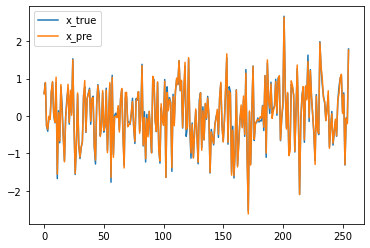

In [ ]:
ind = 10
true1 = y_test[ind,:,0].tolist()
pre1 = out_tensor[ind,:,0].tolist()
plt.plot(range(len(true1)),true1,label='x_true')
plt.plot(range(len(pre1)),pre1, label = 'x_pre')
plt.legend() 

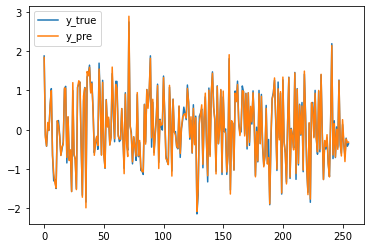

In [ ]:
true2 = y_test[ind,:,1].tolist()
pre2 = out_tensor[ind,:,1].tolist()
plt.plot(range(len(true2)),true2, label='y_true')
plt.plot(range(len(pre2)),pre2, label='y_pre')
plt.legend()

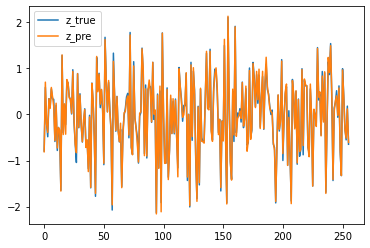

In [ ]:
true3 = y_test[ind,:,2].tolist()
pre3 = out_tensor[ind,:,2].tolist()
plt.plot(range(len(true3)),true3, label = 'z_true')
plt.plot(range(len(pre3)),pre3,label = 'z_pre')
plt.legend()